### Image Segmentation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [2]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels')]

In [3]:
img_dir = path / 'images'

img_files = get_image_files(img_dir)
img_files[:3]

[PosixPath('/home/ubuntu/.fastai/data/camvid/images/Seq05VD_f01320.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images/0006R0_f03420.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images/0006R0_f02610.png')]

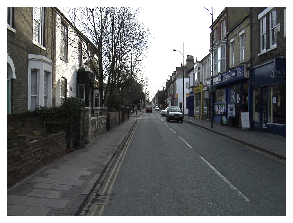

In [4]:
open_image(img_files[0]).show(figsize=(5,5))

In [5]:
lbl_dir = path / 'labels'

lbl_files = get_image_files(lbl_dir)
lbl_files[:3]

[PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0016E5_05190_P.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels/Seq05VD_f00510_P.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0001TP_009360_P.png')]

In [6]:
def get_lbl_file(img_file):
    return lbl_dir / f'{img_file.stem}_P{img_file.suffix}'

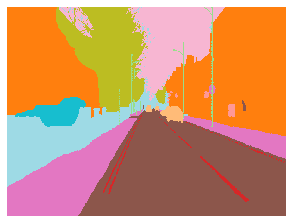

In [7]:
mask = open_mask(get_lbl_file(img_files[0]))
mask.show(figsize=(5,5), alpha=1)

In [8]:
mask.shape

torch.Size([1, 720, 960])

In [9]:
mask.data

tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         ...,
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17]]])

In [10]:
! head {path}/codes.txt

Animal
Archway
Bicyclist
Bridge
Building
Car
CartLuggagePram
Child
Column_Pole
Fence


In [11]:
codes = np.loadtxt(path / 'codes.txt', dtype=str)

In [12]:
src_size = np.array(mask.shape[1:])
src_size

array([720, 960])

In [13]:
size = src_size // 2
size

array([360, 480])

In [14]:
bs = 8  # batch size

In [15]:
SegmentationItemList?

Init signature:
SegmentationItemList(
    *args,
    convert_mode='RGB',
    after_open: Callable = None,
    **kwargs,
)
Docstring:      `ItemList` suitable for segmentation tasks.
File:           ~/.pyenv/versions/3.8.1/envs/py38/lib/python3.8/site-packages/fastai/vision/data.py
Type:           type
Subclasses:     


In [16]:
ItemList?

Init signature:
ItemList(
    items: Iterator,
    path: Union[pathlib.Path, str] = '.',
    label_cls: Callable = None,
    inner_df: Any = None,
    processor: Union[fastai.data_block.PreProcessor, Collection[fastai.data_block.PreProcessor]] = None,
    x: 'ItemList' = None,
    ignore_empty: bool = False,
)
Docstring:      A collection of items with `__len__` and `__getitem__` with `ndarray` indexing semantics.
File:           ~/.pyenv/versions/3.8.1/envs/py38/lib/python3.8/site-packages/fastai/data_block.py
Type:           type
Subclasses:     EmptyLabelList, CategoryListBase, FloatList, MixedItemList, ImageList, PointsLabelList


In [17]:
src = (SegmentationItemList
          .from_folder(img_dir)
          .split_by_fname_file('../valid.txt')  # i guess this is relative to img dir?
                                                # this file contains data to be put in validation set
          .label_from_func(get_lbl_file, classes=codes))  # use classes we read in earlier

In [18]:
data = (src
           .transform(get_transforms(), size=size, tfm_y=True)  # transform y as well
           .databunch(bs=bs)
           .normalize(imagenet_stats))

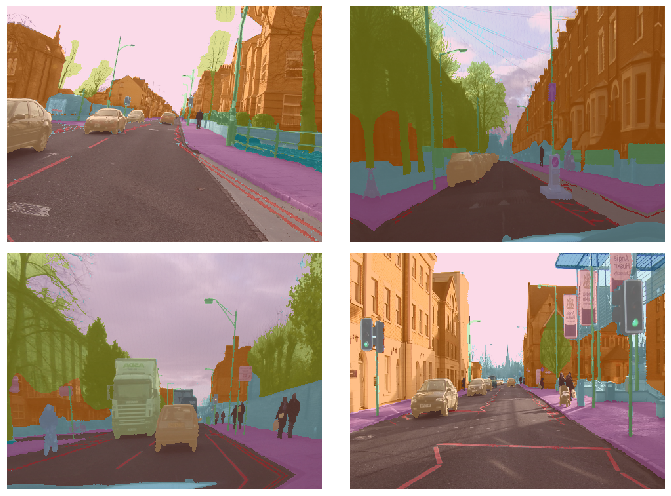

In [19]:
data.show_batch(2, figsize=(10, 7))

In [20]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Void']

def accuracy_camvid(batch, target):
    target = target.squeeze(1)  # this is labeled data
    mask = target != void_code  # mask setting void pixels to false
    
    # remove void pixels in labeled data
    target_without_voids = target[mask]

    # for each prediction, get the class with highest confidence (masking out voids)
    best_prediction_for_each_input = batch.argmax(dim=1)
    predictions_without_voids = best_prediction_for_each_input[mask]
    
    matches = target_without_voids == predictions_without_voids
    
    # calling float() turns True to 1.0 and False to 0.0
    return matches.float().mean()  

In [21]:
learn = unet_learner(data, models.resnet34, metrics=accuracy_camvid, wd=1e-2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ubuntu/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [22]:
lr_find(learn)

epoch,train_loss,valid_loss,accuracy_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


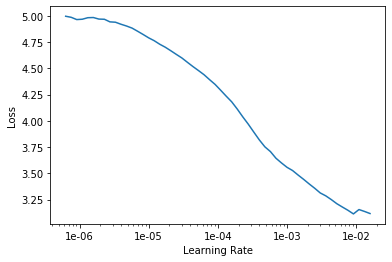

In [23]:
learn.recorder.plot()

In [24]:
lr = 3e-3

In [25]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy_camvid,time
0,1.296493,0.857676,0.776796,00:32
1,0.858145,0.642601,0.837085,00:29
2,0.732260,0.576532,0.848497,00:29
3,0.663196,0.674412,0.847841,00:29
4,0.642457,0.577464,0.854277,00:29
5,0.598160,0.485062,0.876085,00:29
6,0.587665,0.490824,0.874982,00:29
7,0.558567,0.475240,0.876978,00:29
8,0.527528,0.430523,0.887089,00:29
9,0.446006,0.349428,0.895742,00:29


In [26]:
learn.save('camvid-stage-1')

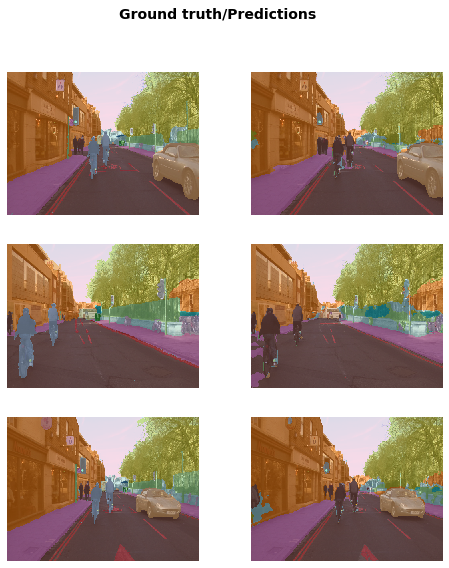

In [27]:
learn.load('camvid-stage-1')
learn.show_results(rows=3, figsize=(8,9))

In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(12, slice(lr/400, lr/4), pct_start=0.8)  # fit one more cycle
                                                             # after unfreezing
                                                             # at a much slower learning rate

epoch,train_loss,valid_loss,accuracy_camvid,time
0,0.376312,0.335724,0.899163,00:31
1,0.370153,0.328948,0.900250,00:30
2,0.360890,0.317313,0.903015,00:30
3,0.353814,0.328792,0.900545,00:30
4,0.340990,0.321975,0.903207,00:31
5,0.337194,0.301459,0.916020,00:31
6,0.321922,0.297544,0.916849,00:30
7,0.317800,0.290940,0.919353,00:30
8,0.301679,0.282461,0.918700,00:30
9,0.297328,0.278958,0.920788,00:30


In [30]:
learn.save('camvid-stage-2')